In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_dataset(up_to= None):
    '''
    Charge les fichiers DVF jusqu'à une année donnée (incluse).

    Paramètres:
        up_to (str): Année maximale à charger, ex: "2020", "2023".

    Return:
        DataFrame Pandas combiné sans doublons.
    '''

    data_files = {
        "2019": "data/ValeursFoncieres-2019-S2.txt",
        "2020": "data/ValeursFoncieres-2020.txt",
        "2021": "data/ValeursFoncieres-2021.txt",
        "2022": "data/ValeursFoncieres-2022.txt",
        "2023": "data/ValeursFoncieres-2023.txt",
        "2024": "data/ValeursFoncieres-2024-S1.txt",
    }

    valid_years = list(data_files.keys())
    if (up_to is not None) and (up_to not in valid_years):
        print("Erreur: \"up_to\" doit être une année entre \"2019\" et \"2024\".")
        return -1

    data_list = []
    for year, path in data_files.items():
        print(f"Chargement {year}...")
        df = pd.read_csv(path, delimiter='|', dtype= str)
        data_list.append(df)
        if (up_to is not None) and (year == up_to):
            break

    data = pd.concat(data_list, ignore_index= True)
    # data.drop_duplicates(inplace=True) #? Fait crash le kernel, désactivé pour le moment
    print(f"\n{len(data):,} lignes chargées au total.")

    return data

In [33]:
def parse_dataset(dataset, min_price= 1_000, max_price= 2_000_000):
    '''
    Parsing des données, on ne garde que les lignes des ventes et de certains types de local.
    Seule les colonnes suivantes sont gardées : "Valeur fonciere", "Date mutation", "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales".
    Les lignes comportant des NaN sont supprimées.
    Ajout de colonnes pour "Année", "Mois", "Jour".
    Valeurs de target plafonnée.

    Paramètres:
        dataset (dataset): strucutre d'un fichier DVF.
        max_price (float): valeur maximum de target.

    Retour:
        dataFrames Pandas, X contenant les features et y contenant la target.
    '''

    if max_price < 0:
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if min_price < 0:
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if min_price >= max_price:
        print("Erreur: \"min_price\" doit être < à \"max_price\"")
        return -1

    dataset = dataset[(dataset["Nature mutation"] == "Vente")]

    dataset = dataset.dropna(subset= ["Date mutation", "Valeur fonciere", "Code departement", "Type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain"])
    dataset["Valeur fonciere"] = dataset["Valeur fonciere"].str.replace(",", ".", regex= False).astype(float)
    dataset["Date mutation"] = pd.to_datetime(dataset["Date mutation"], format="%d/%m/%Y", errors="coerce")
    dataset["Annee"] = dataset["Date mutation"].dt.year
    dataset["Mois"] = dataset["Date mutation"].dt.month
    dataset["Jour"] = dataset["Date mutation"].dt.day
    dataset["Surface reelle bati"] = dataset["Surface reelle bati"].str.replace(",", ".", regex= False).astype(float)
    dataset["Nombre pieces principales"] = dataset["Nombre pieces principales"].astype(int)
    dataset["Surface terrain"] = dataset["Surface terrain"].str.replace(",", ".", regex= False).astype(float)
    dataset["Prix au m2"] = dataset["Valeur fonciere"] / dataset["Surface reelle bati"]

    dataset = dataset[(dataset["Type local"] == "Maison") | (dataset["Type local"] == "Appartement")]
    dataset = dataset[(dataset["Valeur fonciere"] >= min_price) &
                (dataset["Valeur fonciere"] <= max_price) &
                (dataset["Surface reelle bati"] >= 15) &
                (dataset["Surface reelle bati"] <= 300) &
                (dataset["Surface terrain"] <= 10_00) &
                (dataset["Nombre pieces principales"] >= 1) &
                (dataset["Nombre pieces principales"] <= 12)
                # (dataset["Prix au m2"] >= 300) &
                # (dataset["Prix au m2"] <= 10_000)
                ]

    features = ["Date mutation", "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Annee", "Mois", "Jour", "Prix au m2"]
    target = "Valeur fonciere"

    return dataset, features, target

In [34]:
data = load_dataset(up_to= "2019") #TODO crash toujour lorsque load au dessus de 2021

Chargement 2019...

1,967,866 lignes chargées au total.


In [45]:
# dataset, features, target = parse_dataset(data, min_price= 0, max_price= 100_000_000)
dataset, features, target = parse_dataset(data, min_price= 10_000, max_price= 2_000_000)
X = dataset[features]
print("Shape des features:", X.shape)
print("Colonnes:", X.columns.tolist())
print("\nAperçu des données:")
display(X.head())
print("\nRésumé statistique des variables numériques:")
display(X.describe())
print("\nRépartition des types de biens:")
print(X["Type local"].value_counts())

Shape des features: (342952, 10)
Colonnes: ['Date mutation', 'Code departement', 'Type local', 'Surface terrain', 'Surface reelle bati', 'Nombre pieces principales', 'Annee', 'Mois', 'Jour', 'Prix au m2']

Aperçu des données:


,Date mutation,Code departement,Type local,Surface terrain,Surface reelle bati,Nombre pieces principales,Annee,Mois,Jour,Prix au m2
0,2019-07-01,01,Maison,695.0,150.0,5,2019,7,1,1628.000000
1,2019-07-04,01,Maison,888.0,94.0,4,2019,7,4,2074.468085
2,2019-07-04,01,Maison,500.0,94.0,4,2019,7,4,2074.468085
3,2019-07-04,01,Maison,522.0,90.0,3,2019,7,4,1222.555556
6,2019-07-03,01,Maison,557.0,110.0,5,2019,7,3,1458.636364



Résumé statistique des variables numériques:


,Date mutation,Surface terrain,Surface reelle bati,Nombre pieces principales,Annee,Mois,Jour,Prix au m2
count,342952,342952.000000,342952.000000,342952.000000,342952.0,342952.000000,342952.000000,342952.000000
mean,2019-09-28 20:23:07.044251392,443.782112,93.958624,3.967998,2019.0,9.412174,16.734415,3122.830193
min,2019-07-01 00:00:00,0.000000,15.000000,1.000000,2019.0,7.000000,1.000000,37.593985
25%,2019-08-08 00:00:00,218.000000,67.000000,3.000000,2019.0,8.000000,9.000000,1319.444444
50%,2019-09-27 00:00:00,436.000000,90.000000,4.000000,2019.0,9.000000,17.000000,2008.928571
75%,2019-11-16 00:00:00,624.000000,115.000000,5.000000,2019.0,11.000000,25.000000,3180.487805
max,2019-12-31 00:00:00,1000.000000,300.000000,12.000000,2019.0,12.000000,31.000000,124600.000000
std,NaN,263.692114,41.268292,1.496684,0.0,1.766944,9.054466,4791.295846



Répartition des types de biens:
Type local
Maison         297174
Appartement     45778
Name: count, dtype: int64


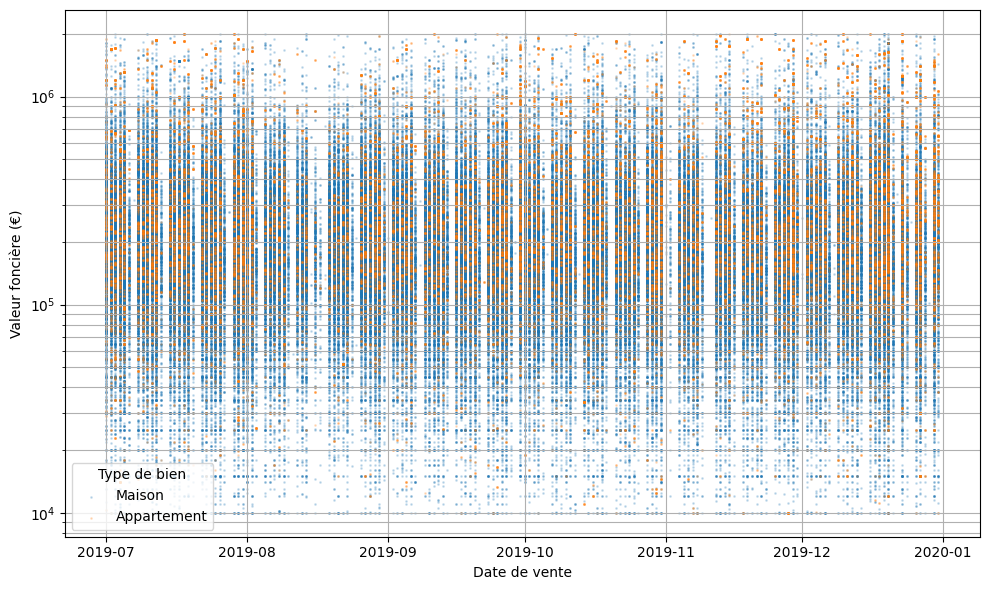

In [46]:
plt.figure(figsize=(10, 6))
for type_local in dataset["Type local"].unique():
    subset = dataset[dataset["Type local"] == type_local]
    plt.scatter(subset["Date mutation"], subset["Valeur fonciere"], label= type_local, alpha= .2, s= 1)
plt.title("")
plt.legend(title="Type de bien")
plt.xlabel("Date de vente")
plt.ylabel("Valeur foncière (€)")
plt.yscale("log")
plt.grid(True, which= "both")
plt.tight_layout()
plt.show()

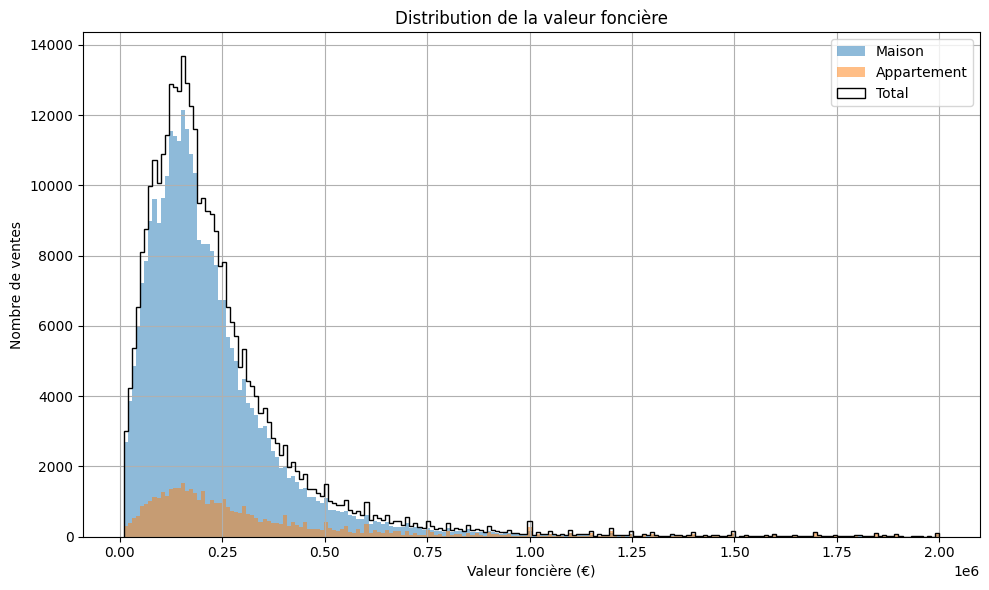

In [47]:
plt.figure(figsize=(10, 6))
for type_local in dataset["Type local"].unique():
    subset = dataset[dataset["Type local"] == type_local]
    plt.hist(subset["Valeur fonciere"], label= type_local, alpha= .5, bins= 200, log= False, density= False)
plt.hist(dataset["Valeur fonciere"], label= "Total", bins= 200, log= False, density= False, histtype= "step", color = 'k')
plt.title("Distribution de la valeur foncière")
plt.xlabel("Valeur foncière (€)")
plt.ylabel("Nombre de ventes")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

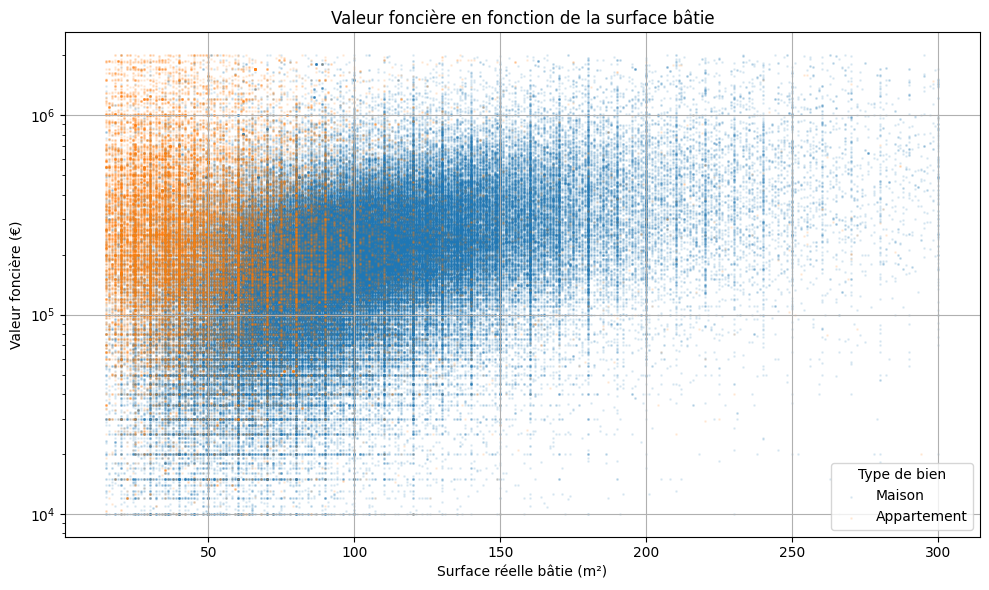

In [48]:
plt.figure(figsize=(10, 6))
for type_local in dataset["Type local"].unique():
    subset = dataset[dataset["Type local"] == type_local]
    plt.scatter(subset["Surface reelle bati"], subset["Valeur fonciere"], label= type_local, alpha= .1, s= 1)
plt.title("Valeur foncière en fonction de la surface bâtie")
plt.xlabel("Surface réelle bâtie (m²)")
plt.ylabel("Valeur foncière (€)")
plt.grid(True)
plt.legend(title="Type de bien")
plt.yscale("log")
plt.tight_layout()
plt.show()

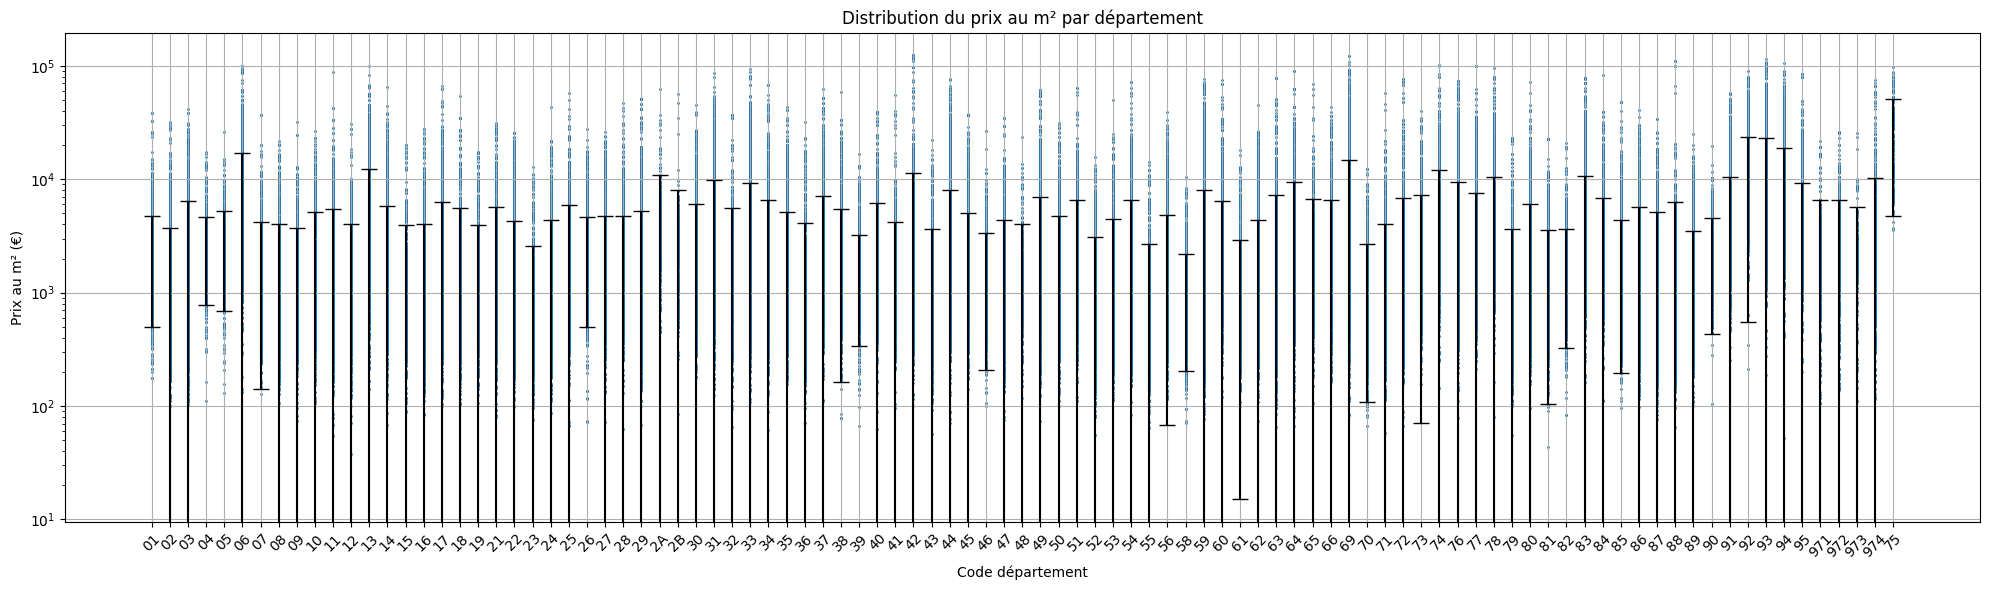

In [49]:
plt.figure(figsize=(20, 6))
plt.scatter(dataset["Code departement"], dataset["Prix au m2"], s= 1)
for departement in dataset["Code departement"].unique():
    subset = dataset[dataset["Code departement"] == departement]
    plt.errorbar(departement, np.mean(subset["Prix au m2"]), yerr= np.std(subset["Prix au m2"], ddof= 1), c= "k", capsize= 6)
plt.title("Distribution du prix au m² par département")
plt.xlabel("Code département")
plt.ylabel("Prix au m² (€)")
plt.xticks(rotation= 45)
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

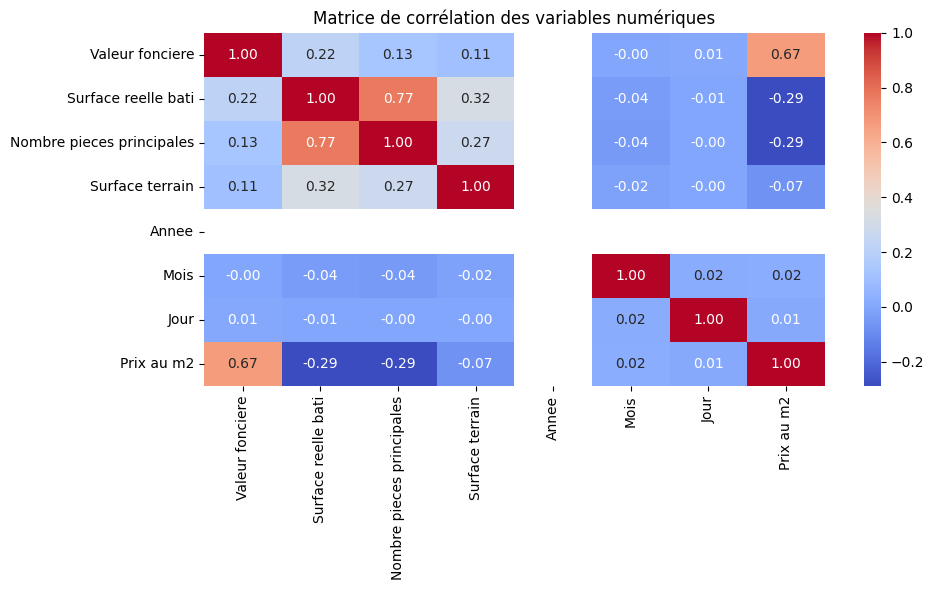

In [50]:
plt.figure(figsize=(10, 6))
sns.heatmap(dataset.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation des variables numériques")
plt.tight_layout()
plt.show()